In [2]:
import pandas as pd

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
cols = ['age', 'workclass', 'fnlwgt', 'education', 'education-num',
        'marital-status', 'occupation', 'relationship', 'race', 'sex',
        'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income']

df = pd.read_csv(url, header=None, names=cols, na_values=' ?', skipinitialspace=True)
df = df.dropna()
df['income'] = df['income'].apply(lambda x: 1 if x.strip() == '>50K' else 0)


In [3]:
def simplify_education(ed):
    ed = ed.strip().lower()
    if ed == "bachelors":
        return "Bachelors"
    elif ed == "masters":
        return "Masters"
    elif ed == "doctorate":
        return "Doctorate"
    elif ed in ["12th", "hs-grad", "some-college", "assoc-acdm", "assoc-voc"]:
        return "High School Graduate"
    else:
        return "High School Dropout"

df['education_simple'] = df['education'].apply(simplify_education)

def simplify_marital_status(m):
    m = m.strip().lower()
    if m.startswith("married"):
        return "Married"
    elif m == "never-married":
        return "Single"
    elif m in ["divorced", "separated"]:
        return "Divorced"
    elif m == "widowed":
        return "Widowed"
    else:
        return "Single"  # default to single if unclear

df['marital_simple'] = df['marital-status'].apply(simplify_marital_status)


In [4]:
features = [
    'age', 'education_simple', 'marital_simple', 'occupation', 'race', 'sex'
]
df_features = df[features + ['income']].copy()

from sklearn.preprocessing import LabelEncoder

label_encoders = {}
for col in ['education_simple', 'marital_simple', 'occupation', 'race', 'sex']:
    le = LabelEncoder()
    df_features[col] = le.fit_transform(df_features[col])
    label_encoders[col] = le


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

X = df_features[features]
y = df_features['income']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

model = RandomForestClassifier(random_state=42, class_weight="balanced")
model.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', random_state=42)

In [6]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=['<=50K', '>50K']))


              precision    recall  f1-score   support

       <=50K       0.90      0.81      0.85      4945
        >50K       0.54      0.73      0.62      1568

    accuracy                           0.79      6513
   macro avg       0.72      0.77      0.74      6513
weighted avg       0.82      0.79      0.80      6513



In [7]:
import gradio as gr
import numpy as np

def get_options(col):
    return label_encoders[col].classes_.tolist()

def predict_income(age, education_simple, marital_simple, occupation, race, sex):
    input_dict = {
        'age': age,
        'education_simple': label_encoders['education_simple'].transform([education_simple])[0],
        'marital_simple': label_encoders['marital_simple'].transform([marital_simple])[0],
        'occupation': label_encoders['occupation'].transform([occupation])[0],
        'race': label_encoders['race'].transform([race])[0],
        'sex': label_encoders['sex'].transform([sex])[0],
    }
    X_input = pd.DataFrame([input_dict])
    proba = model.predict_proba(X_input)[0]
    pred = np.argmax(proba)
    pct = round(proba[pred] * 100, 2)
    if pred == 1:
        return f"There is a {pct}% chance you make more than $50K per year."
    else:
        return f"There is a {pct}% chance you make less than $50K per year."

with gr.Blocks() as demo:
    gr.Markdown("# Income Prediction App")
    gr.Markdown("Enter your info to predict your income category.")

    age = gr.Number(label="Age", value=30)
    education_simple = gr.Dropdown(choices=get_options('education_simple'), label="Education")
    marital_simple = gr.Dropdown(choices=get_options('marital_simple'), label="Marital Status")
    occupation = gr.Dropdown(choices=get_options('occupation'), label="Occupation")
    race = gr.Dropdown(choices=get_options('race'), label="Race")
    sex = gr.Dropdown(choices=get_options('sex'), label="Sex")
    predict_btn = gr.Button("Predict")
    output = gr.Textbox(label="Prediction")

    predict_btn.click(
        fn=predict_income,
        inputs=[age, education_simple, marital_simple, occupation, race, sex],
        outputs=output
    )

demo.launch()


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://4b96c67c415b924a5b.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


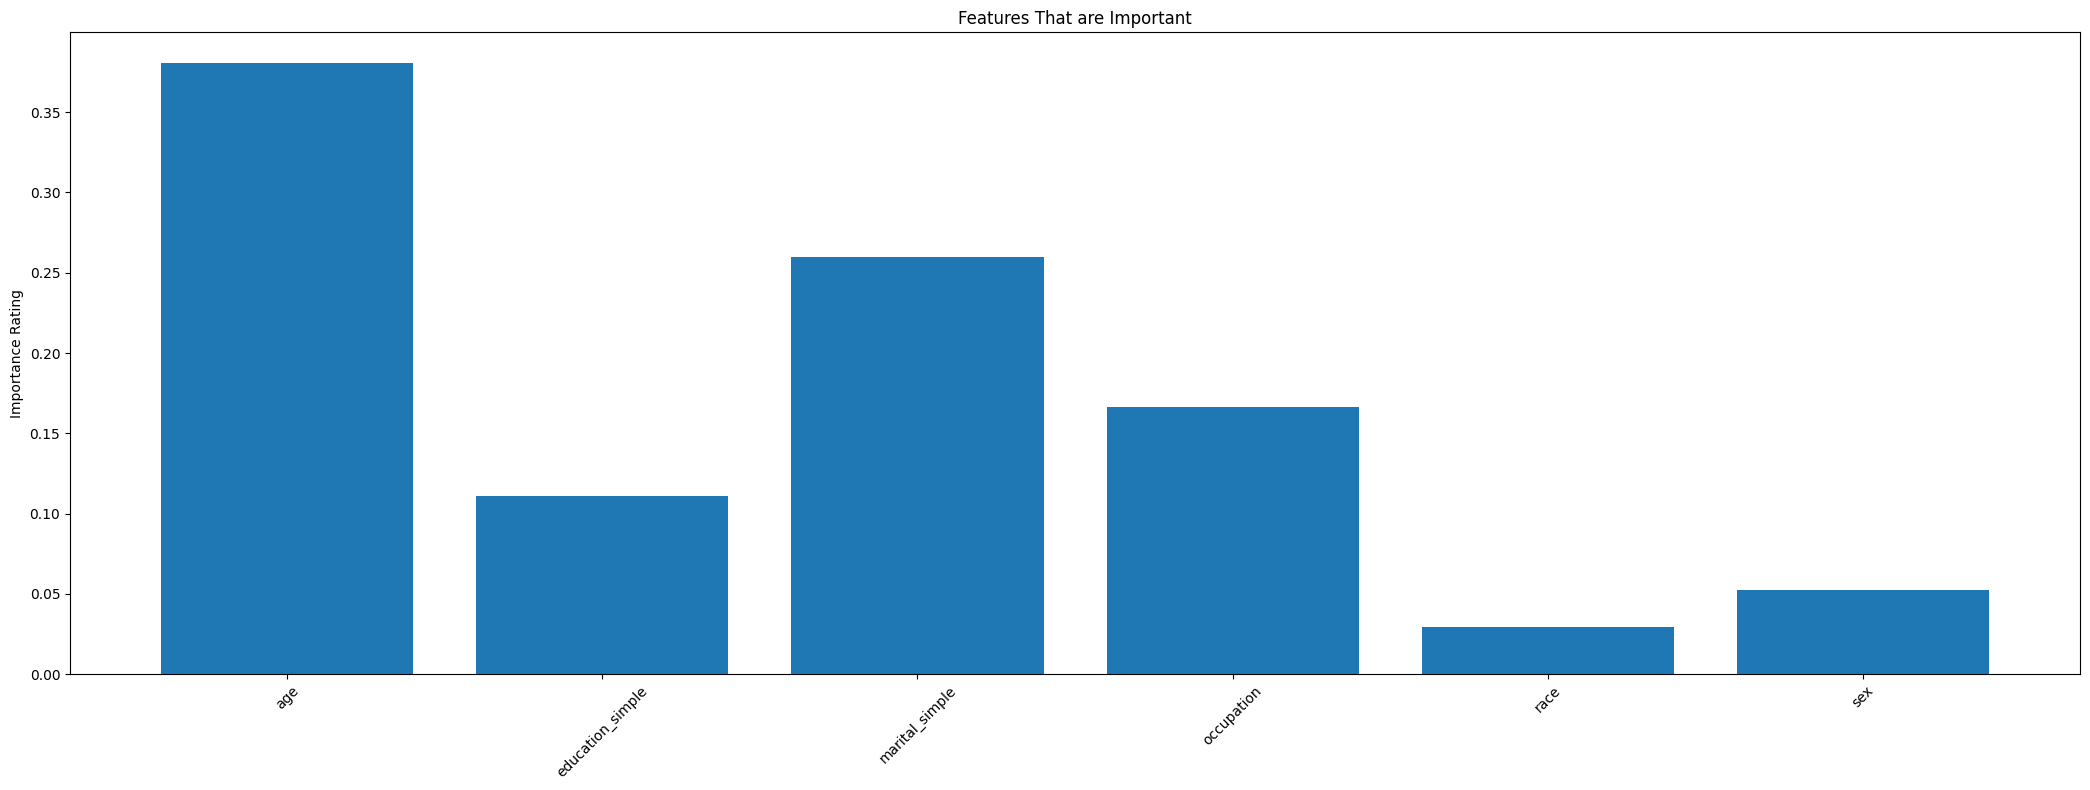

In [15]:
import matplotlib.pyplot as plt

importances = model.feature_importances_
feat_names = features

plt.figure(figsize=(21,8))
plt.bar(feat_names, importances)
plt.ylabel('Importance Rating') #This shows on a scale of 0.00 to 0.35 how important the rating is in percentage points
plt.title('Features That are Important')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
